## map2loop: Topology fom WFS
This notebook reads in two layers from the GSWA server:  geology polygons and fault polylines; and calculates the topological relationships between the different features. Requires compiled cpp code from Vitaliy Ogarko

In [1]:
import subprocess
import geopandas as gpd
import fiona 
import geoplot
import os
import osgeo 
from osgeo import ogr
import sys
import stat
import functools 
import operator  
import matplotlib
import networkx as nx
from shapely.geometry import Polygon

newwd="C:\\Users\\00073294\Dropbox\\loop_minex\\map2model\\"
os.chdir(newwd)
print("Current Working Directory " )

gdal_data = os.environ['GDAL_DATA']
print("***",gdal_data)
print('is dir: ' + str(os.path.isdir(gdal_data)))
gcs_csv = os.path.join(gdal_data, 'gcs.csv')
print('is file: ' + str(os.path.isfile(gcs_csv)))
st = os.stat(gcs_csv)
print('is readable: ' + str(bool(st.st_mode & stat.S_IRGRP)))
os.environ['PROJ_LIB']=r"C:\\Users\\00073294\\AppData\\Local\\Continuum\\anaconda3\\Lib\\site-packages\\pyproj\\proj_dir\\share\\proj"
print(os.getenv('PROJ_LIB'))

Current Working Directory 
*** C:\Program Files\PostgreSQL\11\gdal-data
is dir: True
is file: True
is readable: True
C:\\Users\\00073294\\AppData\\Local\\Continuum\\anaconda3\\Lib\\site-packages\\pyproj\\proj_dir\\share\\proj


## Create bounding box based on inputs

In [2]:
latmin=-23
latmax=-22
longmin=117
longmax=118

bbox=str(latmin)+","+str(longmin)+","+str(latmax)+","+str(longmax)
lat_point_list = [latmin, latmin, latmax, latmax, latmin]
lon_point_list = [longmin, longmax, longmax, longmin, longmin]

bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
crs = {'init': 'epsg:3857'}
polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[bbox_geom]) 

print(bbox)

-23,117,-22,118


## Plot geology polygons and bounding box

In [3]:
#os.environ

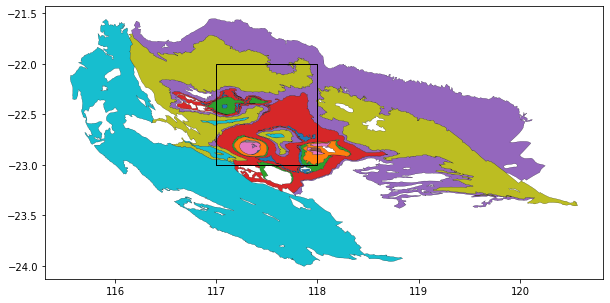

In [4]:
geology=gpd.read_file("https://services.slip.wa.gov.au/public/services/SLIP_Public_Services/Geology_and_Soils_Map_WFS/MapServer/WFSServer/?service=WFS&version=1.0.0&request=GetFeature&typename=SLIP_Public_Services_Geology_and_Soils_Map_WFS:__2_500_000_State_interpreted_bedrock_geology__DMIRS-014_&BBOX="+bbox+"&srs=EPSG:3857")
#geology=geology['geometry'].intersection(polygon)
geology_ll = geology.to_crs('epsg:4326')
#print(geology.crs)
base=geology_ll.plot(column='code',figsize=(10,10),edgecolor='#000000',linewidth=0.2)
polygon.plot(ax=base, color='none',edgecolor='black')
#print(wfs_geology.head())

## Save to file as WKT

In [5]:
sub_geol = geology_ll[['geometry', 'oid','code','unitname','descriptn']]

f= open('data\\out_geology\\T1_500k_geolx.csv',"w+")
f.write("WKT\tOBJECTID\tUNITNAME\tGROUP_\tMIN_AGE_MA\tMAX_AGE_MA\tCODE\tDESCRIPTN\n")
        
print(len(sub_geol)," polygons")
#print(sub_geol)
for i in range(0,len(sub_geol)):
    f.write("\""+str(sub_geol.loc[i].geometry)+"\"\t")
    f.write("\""+str(sub_geol.loc[i].oid)+"\"\t")
    f.write("\""+str(sub_geol.loc[i].unitname)+"\"\t")
    f.write("\""+"SAME"+"\"\t")
    f.write("\""+"0"+"\"\t")
    f.write("\""+"0"+"\"\t")
    f.write("\""+str(sub_geol.loc[i].code)+"\"\t")
    f.write("\""+str(sub_geol.loc[i].descriptn)+"\"\n")
    
f.close()


41  polygons


## Read and save WAROX point data as WKT

303  points


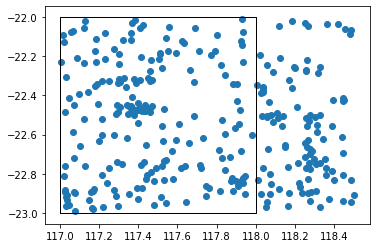

In [6]:
warox = gpd.read_file("data\\test_wa_wgs84\\warox_wgs84.shp")


sub_pts = warox[['geometry', 'GEOPNT_ID','DIP','DIP_DIR']]

f= open('data\\out_points\warox_wgs84x.csv',"w+")
f.write("WKT\tGEOPNT_ID\tDIP\tDIP_DIR\n")

print(len(sub_pts)," points")


#for i in range(0,len(sub_pts)):
#    for j in range(0,len(sub_geol)):
#        if(sub_pts.loc[i].geometry.within(sub_geol.loc[j].geometry)):
#            print(i,j)

for i in range(0,len(sub_pts)):
    line="\""+str(sub_pts.loc[i].geometry)+"\"\t\""+str(sub_pts.loc[i].GEOPNT_ID)+"\"\t\""+\
      str(sub_pts.loc[i].DIP)+"\"\t\""+str(sub_pts.loc[i].DIP_DIR)+"\"\n"    
    f.write(functools.reduce(operator.add, (line)))
    
f.close()

base=sub_pts.plot()
polygon.plot(ax=base, color='none',edgecolor='black')


## Plot faults and bounding box

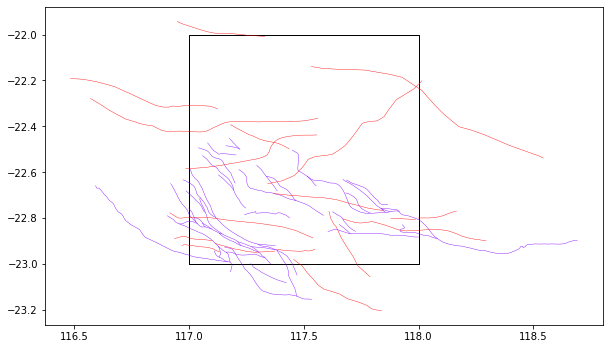

In [7]:
#bbox='-23,117,-22,118'
lines=gpd.read_file("https://services.slip.wa.gov.au/public/services/SLIP_Public_Services/Geology_and_Soils_Map_WFS/MapServer/WFSServer/?service=WFS&version=1.0.0&request=GetFeature&typename=SLIP_Public_Services_Geology_and_Soils_Map_WFS:__2_500_000_State_interpreted_bedrock_geology_structural_lines__DMIRS-013_&BBOX="+bbox+"&srs=EPSG:3857")
#print(lines)
#lines.plot(column='feature',figsize=(10,10),linewidth=0.2)

lines_ll = lines.to_crs('epsg:4326')
#print(geology.crs)
base2=lines_ll.plot(cmap='rainbow',column='feature',figsize=(10,10),linewidth=0.4)
polygon.plot(ax=base2, color='none',edgecolor='black')


## Save faults to file as WKT

In [8]:
sub_lines = lines[['geometry', 'oid','feature']]

f= open('data\\out_faults\\T1_500k_linearx.csv',"w+")
f.write("WKT\tOBJECTID\tFEATURE\n")

print(len(sub_lines)," polylines")

for i in range(0,len(sub_lines)):
    f.write("\""+str(sub_lines.loc[i].geometry)+"\"\t")
    f.write("\""+str(sub_lines.loc[i].oid)+"\"\t")
    f.write("\""+str(sub_lines.loc[i].feature)+"\"\n")
    
f.close()

98  polylines


## Calculate topology

In [9]:
subprocess.run(['map2model.exe', 'Parfilex'])

CompletedProcess(args=['map2model.exe', 'Parfilex'], returncode=0)

## Simple network graph of the geology with legend

C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


0    'Fortescue Group, sequence 3'
1    'Fortescue Group'
2    'Fortescue Group, sequence 1'
3    'Shingle Creek Group'
4    'Turee Creek Group'
5    'Rocklea Inlier greenstones'
6    'Hamersley Group, lower'
7    'Hamersley Group, upper'
8    'Fortescue Group, sequence 4'
9    'Milli Milli Inlier greenstones'
10    'Milli Milli Inlier metagranitc unit'
11    'Fortescue Group, sequence 5'
12    'Wyloo Group'
13    'Fortescue Group, sequence 2'
14    'Rocklea Inlier metagranitic unit'


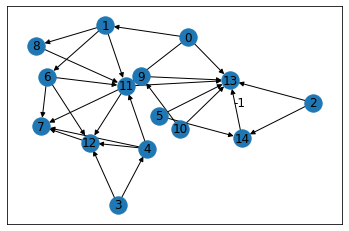

In [11]:
G=nx.read_gml("output\\graph.gml",label='id')
selected_nodes = [n for n,v in G.nodes(data=True) if n >=0]
nx.draw_networkx(G, pos=nx.kamada_kawai_layout(G), arrows=True, nodelist=selected_nodes)

nlist=list(G.nodes.data('LabelGraphics'))
nlist.sort()
for no in nlist:
    if(no[0]>=0):
        elem=str(no[1]).replace("{'text':","").replace(", 'fontSize': 14}","")
        #second=elem.split(":").replace("'","")
        print(no[0]," ",elem)

## Detailed Tology via dot or gml format files
For a more detailed look we can open up the online version of <b>yEd</b> <a href="https://www.yworks.com/yed-live/" >https://www.yworks.com/yed-live/</a>  and load in the *.dot file that we will now create or dowload the <a href="https://www.yworks.com/products/yed/download">yEd program</a> and look at the *.gml files in the <b>output</b> directory

In [ ]:
from networkx.drawing.nx_pydot import write_dot

import filer,gfiler

filepath=filer.gui_fname().decode('UTF-8')
write_dot(G,filepath)

http://localhost:8888/notebooks/Dropbox/1_Jupyter_notebooks/Input_tests/map2strat_for_gempy.ipynb